In [133]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping



In [134]:
df = pd.read_csv('movie_statistic_dataset.csv')

df.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


In [135]:
print(df.columns)

Index(['movie_title', 'production_date', 'genres', 'runtime_minutes',
       'director_name', 'director_professions', 'director_birthYear',
       'director_deathYear', 'movie_averageRating', 'movie_numerOfVotes',
       'approval_Index', 'Production budget $', 'Domestic gross $',
       'Worldwide gross $'],
      dtype='object')


In [136]:
X = df[['runtime_minutes', 'movie_averageRating', 'movie_numerOfVotes', 'approval_Index', 'Production budget $', 'Domestic gross $', 'Worldwide gross $']]
# X = df[['runtime_minutes', 'movie_averageRating', 'approval_Index', 'Production budget $', 'Worldwide gross $']]
# director = pd.get_dummies(df['director_name'])
# X = pd.concat([X, director], axis=1)
genres_dummies = df['genres'].str.get_dummies(sep=',')
# y = pd.get_dummies(df['genres'])
y = np.asarray(genres_dummies)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [138]:
print(X_train.shape[1])
print(y_train.shape)
print(y_train.shape[1])

7
(3504, 24)
24


In [139]:
# Normalización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model1 = Sequential([
    Dense(512, input_shape=(X_train_scaled.shape[1],), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model2 = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(y_train.shape[1], activation='softmax')
])

model3 = Sequential([
    Dense(200, input_shape=(X_train_scaled.shape[1],), activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    LayerNormalization(),
    Dense(140, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    LayerNormalization(),
    Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    LayerNormalization(),
    Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    LayerNormalization(),
    Dense(y_train.shape[1], activation='softmax')
])


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [140]:
optimizer1 = Adam(learning_rate=0.001, clipnorm=1.0)

model1.compile(
    optimizer=optimizer1, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    run_eagerly=True
)

optimizer2 = Adam(learning_rate=0.0001, clipnorm=1.0)

model2.compile(
    optimizer=optimizer2, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    run_eagerly=True
)

optimizer3 = Adam(learning_rate=0.001, clipnorm=1.0)

model3.compile(
    optimizer=optimizer3, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    run_eagerly=True
)

In [141]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_history = model1.fit(
    X_train_scaled, 
    y_train, 
    epochs=100, 
    validation_split=0.25, 
    batch_size=64, 
    verbose=2,
    callbacks=[early_stopping]
)

model1.evaluate(X_test_scaled, y_test, verbose=2)

model2_history =  model2.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

model3_history =  model3.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

Epoch 1/100
42/42 - 5s - 131ms/step - accuracy: 0.1693 - loss: 14.2583 - val_accuracy: 0.1495 - val_loss: 25.4112
Epoch 2/100
42/42 - 5s - 113ms/step - accuracy: 0.1522 - loss: 233.0863 - val_accuracy: 0.1495 - val_loss: 526.5849
Epoch 3/100
42/42 - 5s - 112ms/step - accuracy: 0.1511 - loss: 2615.8748 - val_accuracy: 0.1495 - val_loss: 4352.1899
Epoch 4/100
42/42 - 5s - 114ms/step - accuracy: 0.1537 - loss: 14187.4707 - val_accuracy: 0.1495 - val_loss: 17108.0703
Epoch 5/100
42/42 - 5s - 110ms/step - accuracy: 0.1533 - loss: 50169.7500 - val_accuracy: 0.1495 - val_loss: 58050.1367
Epoch 6/100
42/42 - 5s - 111ms/step - accuracy: 0.1503 - loss: 134910.7188 - val_accuracy: 0.1495 - val_loss: 129407.7188
Epoch 7/100
42/42 - 5s - 110ms/step - accuracy: 0.1564 - loss: 296759.7500 - val_accuracy: 0.1495 - val_loss: 288206.7500
Epoch 8/100
42/42 - 5s - 110ms/step - accuracy: 0.1556 - loss: 578024.3750 - val_accuracy: 0.1495 - val_loss: 504301.5938
Epoch 9/100
42/42 - 5s - 112ms/step - accuracy

In [142]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

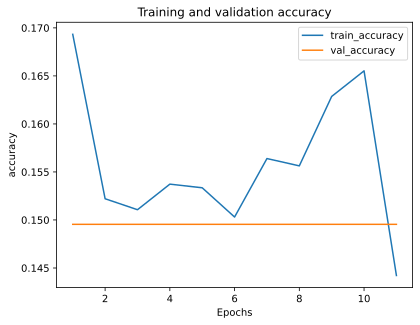

In [143]:
plot_metric(model_history, 'accuracy')

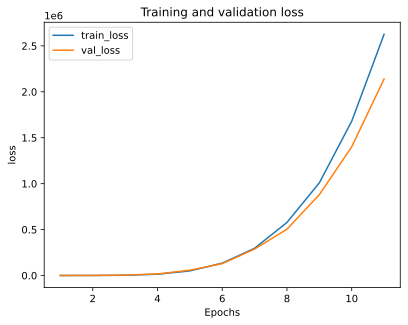

In [144]:
plot_metric(model_history, 'loss')

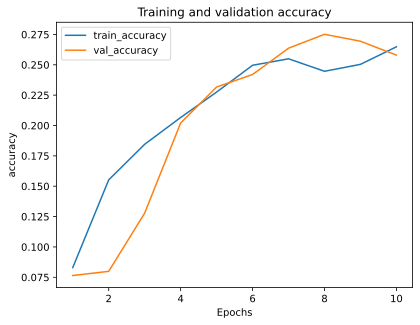

In [145]:
plot_metric(model2_history, 'accuracy')

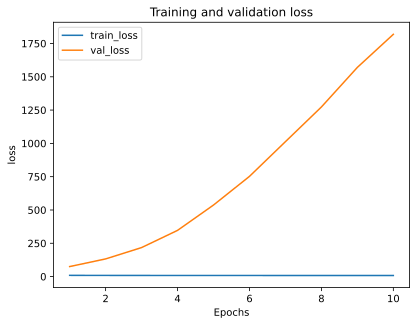

In [146]:
plot_metric(model2_history, 'loss')

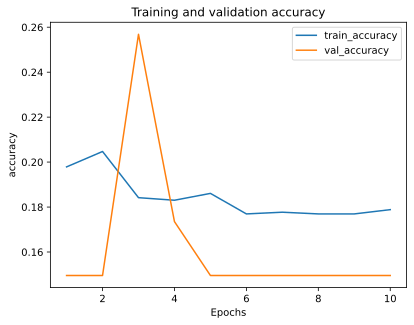

In [147]:
plot_metric(model3_history, 'accuracy')

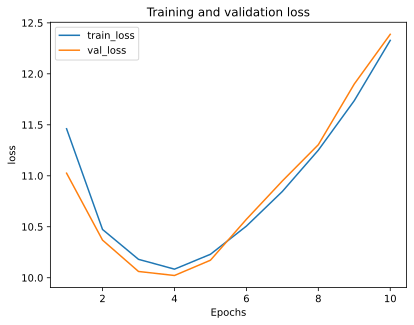

In [148]:
plot_metric(model3_history, 'loss')

In [149]:
model1.evaluate(X_test, y_test, verbose=2)

28/28 - 1s - 24ms/step - accuracy: 0.1655 - loss: 693425088.0000


[693425088.0, 0.16552510857582092]

In [150]:
model2.evaluate(X_test, y_test, verbose=2)

28/28 - 1s - 21ms/step - accuracy: 0.2797 - loss: 8.2013


[8.201281547546387, 0.27968037128448486]

In [151]:
model3.evaluate(X_test, y_test, verbose=2)

28/28 - 1s - 44ms/step - accuracy: 0.1655 - loss: 12.2043


[12.204339027404785, 0.16552510857582092]